<h1><center>Foundations of Deep Learning</center></h1>


<h2><center>Convolution Neural Networks</center></h2>

---

#### What is Convolution

3Blue1Brown explains it best:

https://www.youtube.com/watch?v=KuXjwB4LzSA

In practice, especially for images, instead of performing convolution, we perform cross correlation operation (and call it Convolution !!)

What is the difference?
Cross correlation is performing colvolution, but without inverting the kernel function. 

https://en.wikipedia.org/wiki/Cross-correlation

<br>

#### Learnable Convolution Kernels

Convolution Neural Networks are composed of multiple layers of cross-correlation operators with learnable kernels.

<br>

#### Max Pooling

Max pooling is a pooling technique where we select the max value from the image masked by the max pooling kernel. We then slide this kernel across our image, resulting in a smaller image. 

https://www.youtube.com/watch?v=ZjM_XQa5s6s

<br>

#### Conv Layers in PyToch
We will use 2D conv layers and max pool layers from PyTorch to create our model

+ https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
+ https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

---



This assignment has 3 tasks:
1. Training a ConvNet on CIFAR10 dataset
2. Data Augmentation 
3. Adversarial Samples

You can change your model hyperparameters for task 1, keep the model structure same for tasks 2 and 3

You can use inbuilt torch or sklearn functionalities wherever possible.

Provide detailed explaination for each observation.


In [1]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pprint
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)

In [2]:
transform=T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform = transform
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
40000 10000 10000


In [3]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
}
idx_to_class = {i:c for c, i in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(10)]

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

## Task 1
Train a decently fit (no underfitting or overfitting) neural network on the CIFAR 10 dataset. 
+ Keep track of your validation loss to select the best model
+ You are free to change network hyperparameters and batch size
+ You are free to change optimizer settings and loss function
+ Run your model 5 times with different seeds and report mean and standard deviation of the following metrices on Test Set:
  1. Accuracy for each class
  2. Precision for each class
  3. Recall for each class
  4. F1 score for each class
  5. Visualize the Confusion Matrix (use only mean values for this)



In [5]:
class ConvolutionNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(ConvolutionNeuralNetwork, self).__init__()
    self.conv = torch.nn.Sequential(
      torch.nn.Conv2d(3, 64, 5),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, 5),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2),
      torch.nn.Conv2d(128, 128, [5,5]),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 128, [5,5]),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2)
    )

    self.fc1 = torch.nn.Linear(512, 128)
    self.fc2 = torch.nn.Linear(128, 128)
    self.fc3 = torch.nn.Linear(128, 10)
    # Added a dropout to help with the overfitting of the model
    self.dropout = torch.nn.Dropout(0.6)
  
  def forward(self, data):
    bs = data.shape[0]
    data = self.conv(data)
    data = data.reshape(bs, -1)
    data = self.dropout(torch.relu(self.fc1(data)))
    data = self.dropout(torch.relu(self.fc2(data)))
    logits = self.fc3(data)
    return logits

In [6]:
################################################
# The hyperparameters, parameters and datasets for the model.
################################################
batch_size = 500 #reduced the batch size to help attain better validation acccuracy.
n_epochs = 50 
train_data = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)


Observations:
1. I tried running the model by updating the learning rate but increasing the learning rate the model converged over early and we could not attain a good training loss. But if I reduced the learning rate then the model was not converging and I had to increase the number of epochs. Which slowed the training process.
2. Adding a weight delay didn't help much tiwh the model convergence and accuracy as it was a slow process and I couldn't see any progress even with 100 epochs. Tried with both increasing and decreasing batch size.
3. Dropout helped reduce the overfitting and worked well for the model.
4. Changing momentum got the model overfit at a very early stage and didn't properly train the model.
5. Adding the number of layers incrfesed the model complexity and helped with better convergence over the 60 epochs but then the model accuracy was still 63% therefore I shifted back to the sample layers. 
6. Before the input datasets was normalized the accuracy of the model before data Augmentation was almost same as the after the data Augmentation (with 0.8% increase on validation and test accuracy when trained on augmented train data). But after the input dataset was normalised the accuracy of the model on the validation and test data showed a decreasing trend. 
7. When Task 3 was performed after introducing the gaussian noise to the dataset it was observed that the test accuracy was lower on the models trained in task 1 as compared to the test accuracy of Task 1. Whereas opposite trends were seen in the Task 2 models i.e the test accuracy on the task2 models on the noisy data was better than on the augmented data.

In [7]:
def plot_loss(t_loss_lst, v_loss_list):
  number_of_epochs = [*range(n_epochs)]

  plt.plot(number_of_epochs, t_loss_lst)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss per epoch")
  plt.show()

  plt.plot(number_of_epochs, t_loss_lst)
  plt.plot(number_of_epochs, v_loss_list)
  plt.title('Training vs Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.show()

Testing and Validating the Model along with computing the training and validation loss.


In [8]:
#Function to train and validate the model 
def training_validation_model():
  training_loss_list = []
  validation_loss_list = []
  min_vloss = np.Inf 
  
  for epoch in range(1, n_epochs+1):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # Tracking training and validation loss
    t_loss = 0.0
    v_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in enumerate(train_data):
        inputs, labels = target
        inputs, labels = inputs.to(device), labels.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the batch loss
        loss = loss_fn(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        t_loss += loss.item()*inputs.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in enumerate(val_data):
        inputs, labels = target
        inputs, labels = inputs.to(device), labels.to(device)


        with torch.no_grad():
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(inputs)
          # calculate the batch loss
          loss = loss_fn(output, labels)
          # update average validation loss 
          v_loss += loss.item()*inputs.size(0)

          # convert output probabilities to predicted class
          probs = torch.argmax(output, dim=1)    
          # compare predictions to true label
          correct_tensor = probs.eq(labels.data.view_as(probs))
          correct = np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
          for i in range(labels.shape[0]):
              label = labels[i]
              class_correct[label] += correct[i].item()
              class_total[label] += 1
    
    # calculate average losses
    t_loss = t_loss/len(train_data.dataset)
    v_loss = v_loss/len(val_data.dataset)
    training_loss_list.append(t_loss)
    validation_loss_list.append(v_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, t_loss, v_loss))
    
    # tracking decrease in validation loss
    if v_loss <= min_vloss:
        print('Validation loss decreased ({:.6f} --> {:.6f})'.format(min_vloss,v_loss))
        min_vloss = v_loss
    
    for i in range(10):
      if class_total[i] > 0:
        print('Validation Accuracy of %5s: %2d%% (%2d/%2d)' % (
            idx_to_class[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
        print('Validation Accuracy of %5s: N/A (no training examples)' % (idx_to_class[i]))

    print('\nValidation Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))
  plot_loss(training_loss_list, validation_loss_list)

In [9]:
# n_epochs = 50
#training_validation_model()

Calculating the model metrices

In [10]:
#Function to compute the metrics for validation and testing.
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns

classes = len(idx_to_class)
iter = 5
#tracking the overall metrics per iterations.
overall_accuracy = np.empty([iter,classes])
overall_precision = np.empty([iter,classes])
overall_recall = np.empty([iter,classes]) 
overall_f1_score = np.empty([iter,classes])

def performance_eval(true_labels, pred_labels, class_names, class_correct, class_total):
  global overall_accuracy, overall_precision, overall_recall, overall_f1_score

  #generating the classification_report per iteration
  eval_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict = True)
  precision = np.array([eval_report[name]['precision'] for name in class_names])
  recall = np.array([eval_report[name]['recall'] for name in class_names])
  f1_score = np.array([eval_report[name]['f1-score'] for name in class_names])
  accuracy = np.array([class_correct[i]/class_total[i] for i in range(len(class_names))])

  overall_accuracy = np.vstack([overall_accuracy, accuracy])
  overall_precision = np.vstack([overall_precision, precision])
  overall_recall = np.vstack([overall_recall, recall])
  overall_f1_score = np.vstack([overall_f1_score, f1_score])


  print('Overall Accuracy: {:.2f}%\n'.format(100*eval_report['accuracy']))
  cm = confusion_matrix(true_labels, pred_labels)

  #Plotting the confusion matrix
  plot_cm = np.zeros((classes,classes))
  for i in range(classes):
      for j in range(classes):
          plot_cm[i,j] = cm[i,j]/np.sum(cm[i,:])

  #Plotting the heatmap of the confusion matrix
  plt.figure(figsize=(20,20))
  sns.set(font_scale=1.0)
  df = sns.heatmap(plot_cm, annot=True,fmt='.2', cmap='Accent',xticklabels= class_names , yticklabels= class_names)

  print(f'Confusion Matrix \n{cm}') 
  for i in range(len(class_names)):
    print(f'Class Name: {class_names[i]}')
    print('\tTest Accuracy = {:.2f}%'.format(accuracy[i] * 100))
    print('\tTest Precision = {:.2f}%' .format(precision[i]*100))
    print('\tTest Recall = {:.2f}%' .format(recall[i]*100))
    print('\tTest F1 Score = {:.2f}%' .format(f1_score[i]*100))
  
  print('Classification Report')
  print(classification_report(true_labels, pred_labels, target_names=class_names))

Testing the model and calculating the testing loss along with the relevant metrices.

In [11]:
#Function to test the model
def testing_model():
  
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  total_labels = []
  total_probs = []

  #creating the confusion matrix
  cm = np.zeros((len(class_names), len(class_names)))

  model.eval()
  # iterate over test data
  for data, target in enumerate(test_data):
      inputs, labels = target
      inputs, labels = inputs.cuda(), labels.cuda()

      with torch.no_grad():
        output = model(inputs)
        probs = torch.argmax(output, dim=1)

        # calculate the batch loss
        loss = loss_fn(output, labels)
        # update test loss 
        test_loss += loss.item()*inputs.size(0)
        total_labels += labels.cpu().numpy().tolist()
        total_probs += probs.cpu().numpy().tolist()

        correct_tensor = probs.eq(labels.data.view_as(probs))
        correct = np.squeeze(correct_tensor.cpu().numpy())

        # calculate test accuracy for each object class
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  # average test loss
  test_loss = test_loss/len(test_data.dataset)
  print('Test Loss: {:.6f}'.format(test_loss))

  #Calculating the performance metrics
  performance_eval(total_labels,total_probs,class_names, class_correct, class_total)


In [12]:
#testing_model()

Running the model (training, testing and validation) for 5 different seed values.

In [13]:
#Training the model on 5 seeds and training and validating  
def iterative_running(task_number):
  global iter, classes, overall_accuracy, overall_f1_score, overall_precision, overall_recall
  iter = 5
  classes = len(class_names)
  overall_accuracy = np.empty([iter,classes])
  overall_precision = np.empty([iter,classes])
  overall_recall = np.empty([iter,classes]) 
  overall_f1_score = np.empty([iter,classes])

  for iter in range(5):
    global batch_size, n_epochs, train_data, test_data, val_data, loss_fn, model, optimizer
    #################################
    # Updating the seed value 
    #################################
    seed = random.randrange(100,3456) 
    random.seed(seed)
    torch.manual_seed(seed)
    
    print('Iteration : {}/5 \t Seed Value: {}'.format(iter,seed))

    ################################################
    # Model reinitalization
    ################################################
    batch_size = 500
    n_epochs = 50
    train_data = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_data = DataLoader(test_dataset, batch_size = batch_size)
    val_data = DataLoader(val_dataset, batch_size = batch_size)

    loss_fn = torch.nn.CrossEntropyLoss()
    model = ConvolutionNeuralNetwork().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)

    ################################################
    # Training and validation the model for 50 epochs
    ################################################

    training_validation_model()
    torch.save(model.state_dict(), f'model_{str(task_number)}_{str(iter)}.pt')

    ################################################
    # Testing the model
    ################################################
    testing_model()

  ################################################
  # Mean of accuracy, precision, recall and f1-score
  ################################################

  mean_accuracy = np.mean(overall_accuracy, axis=0)
  mean_precision = np.mean(overall_precision, axis=0)
  mean_f1_score = np.mean(overall_f1_score, axis=0)
  mean_recall = np.mean(overall_recall, axis=0)

  std_accuracy = np.std(overall_accuracy, axis=0)
  std_precision = np.std(overall_precision, axis=0)
  std_f1_score = np.std(overall_f1_score, axis=0)
  std_recall = np.std(overall_recall, axis=0)

  for i in range(len(class_names)):
      print(f'Class Name: {class_names[i]}')
      print('\tAccuracy \tMean = {:.2f}% \tStandard Deviation = {:.2f}%'.format(mean_accuracy[i] * 100, std_accuracy[i]*100))
      print('\tPrecision \tMean = {:.2f}% \tStandard Deviation = {:.2f}%'.format(mean_precision[i] * 100, std_precision[i]*100))
      print('\tRecall \tMean = {:.2f}% \tStandard Deviation = {:.2f}%'.format(mean_recall[i] * 100, std_recall[i]*100))
      print('\tF1 Score \tMean = {:.2f}% \tStandard Deviation = {:.2f}%'.format(mean_f1_score[i] * 100, std_f1_score[i]*100))


Training & Testing for TASK 1
Iteration : 0/5 	 Seed Value: 3287
Epoch: 1 	Training Loss: 2.303314 	Validation Loss: 2.301642
Validation loss decreased (inf --> 2.301642)
Validation Accuracy of airplane:  0% ( 0/1007)
Validation Accuracy of automobile:  0% ( 0/1008)
Validation Accuracy of  bird:  0% ( 0/1005)
Validation Accuracy of   cat: 100% (998/998)
Validation Accuracy of  deer:  0% ( 0/947)
Validation Accuracy of   dog:  0% ( 0/999)
Validation Accuracy of  frog:  0% ( 0/983)
Validation Accuracy of horse:  0% ( 0/1001)
Validation Accuracy of  ship:  0% ( 0/1029)
Validation Accuracy of truck:  0% ( 0/1023)

Validation Accuracy (Overall):  9% (998/10000)
Epoch: 2 	Training Loss: 2.300991 	Validation Loss: 2.297991
Validation loss decreased (2.301642 --> 2.297991)
Validation Accuracy of airplane:  0% ( 0/1007)
Validation Accuracy of automobile:  9% (94/1008)
Validation Accuracy of  bird:  0% ( 0/1005)
Validation Accuracy of   cat: 88% (887/998)
Validation Accuracy of  deer:  2% (26/94

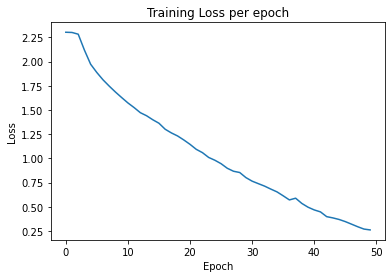

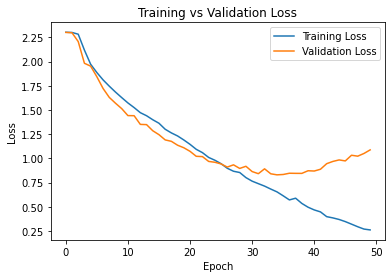

Test Loss: 1.095267
Overall Accuracy: 74.45%

Confusion Matrix 
[[854  14  32  13   5   8   5   3  42  24]
 [ 21 836   7  10   2   4  11   3  40  66]
 [ 84   4 656  68  60  63  31  21   8   5]
 [ 26   1  79 540  38 216  41  23  22  14]
 [ 19   1 100  58 694  37  27  52   9   3]
 [  8   0  44 160  26 714   7  37   2   2]
 [  6   5  59 100  26  16 777   6   2   3]
 [ 20   0  20  26  64 104   4 752   2   8]
 [113  20  10  14   3   3   1   2 815  19]
 [ 40  52   7  17   6   4   6  27  34 807]]
Class Name: airplane
	Test Accuracy = 85.40%
	Test Precision = 71.70%
	Test Recall = 85.40%
	Test F1 Score = 77.96%
Class Name: automobile
	Test Accuracy = 83.60%
	Test Precision = 89.60%
	Test Recall = 83.60%
	Test F1 Score = 86.50%
Class Name: bird
	Test Accuracy = 65.60%
	Test Precision = 64.69%
	Test Recall = 65.60%
	Test F1 Score = 65.14%
Class Name: cat
	Test Accuracy = 54.00%
	Test Precision = 53.68%
	Test Recall = 54.00%
	Test F1 Score = 53.84%
Class Name: deer
	Test Accuracy = 69.40%
	Test P

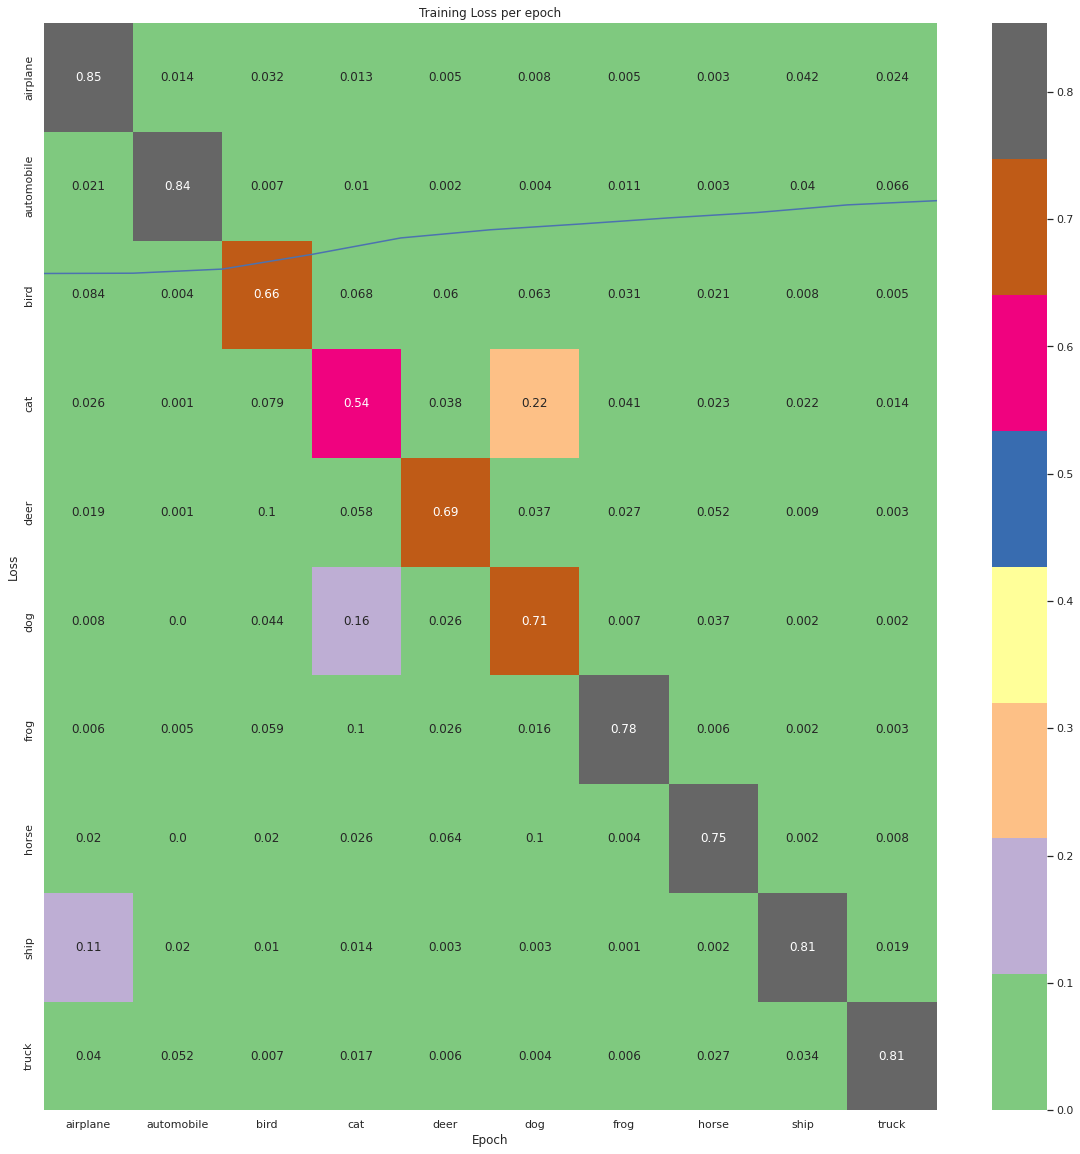

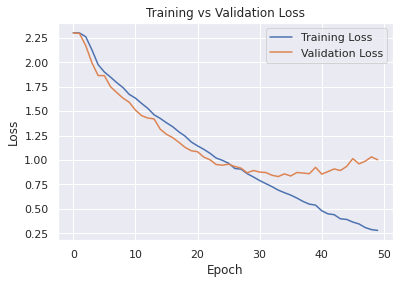

Test Loss: 0.993747
Overall Accuracy: 74.89%

Confusion Matrix 
[[760  14  62  19  12   3  10  14  78  28]
 [ 14 849   6  13   3   2  17   1  40  55]
 [ 53   4 626 123  66  46  52  18   8   4]
 [ 13   1  49 644  40 152  47  16  22  16]
 [ 16   1  74  75 704  37  41  45   5   2]
 [ 10   2  30 271  26 604  15  31   5   6]
 [  4   6  41  89  14   8 827   3   4   4]
 [ 12   0  18  37  55  81   4 778   4  11]
 [ 48  10   4  21   3   2   2   3 889  18]
 [ 33  64   8  19   4   4   6  23  31 808]]
Class Name: airplane
	Test Accuracy = 76.00%
	Test Precision = 78.92%
	Test Recall = 76.00%
	Test F1 Score = 77.43%
Class Name: automobile
	Test Accuracy = 84.90%
	Test Precision = 89.27%
	Test Recall = 84.90%
	Test F1 Score = 87.03%
Class Name: bird
	Test Accuracy = 62.60%
	Test Precision = 68.19%
	Test Recall = 62.60%
	Test F1 Score = 65.28%
Class Name: cat
	Test Accuracy = 64.40%
	Test Precision = 49.12%
	Test Recall = 64.40%
	Test F1 Score = 55.73%
Class Name: deer
	Test Accuracy = 70.40%
	Test P

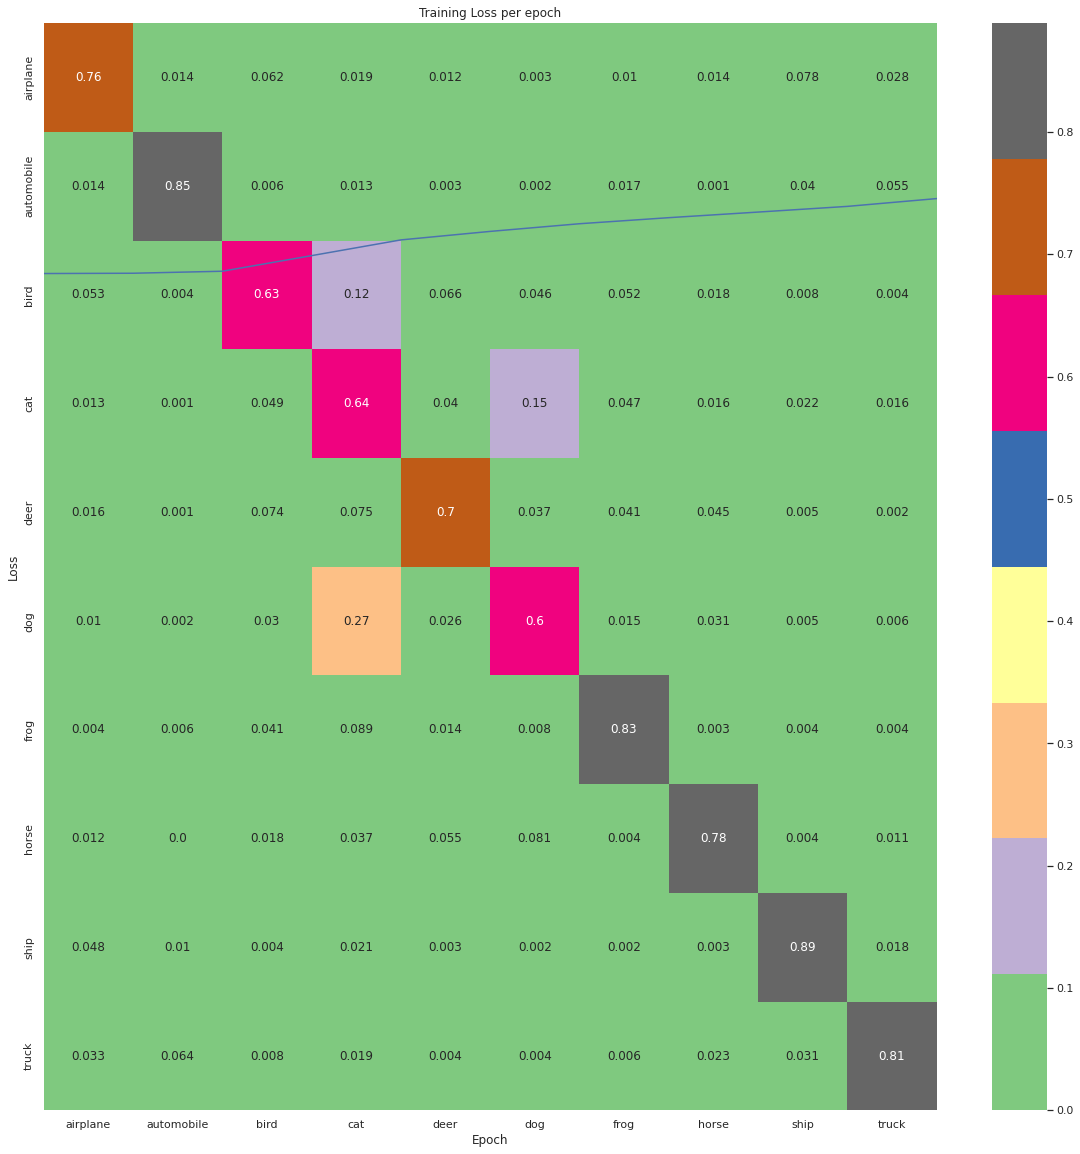

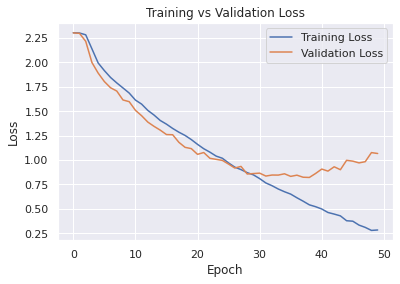

Test Loss: 1.064251
Overall Accuracy: 74.37%

Confusion Matrix 
[[669  20 119  27  26   4  16   7  77  35]
 [ 10 867   7  13   3   2  17   2  19  60]
 [ 29   2 649  62 110  64  57  14   7   6]
 [  5   4  54 571  64 185  78  16  11  12]
 [ 12   0  40  55 749  46  46  44   3   5]
 [  5   0  43 172  45 662  16  51   2   4]
 [  2   8  31  64  36   7 848   3   0   1]
 [  9   1  20  33  77  82   5 751   0  22]
 [ 48  34  20  29   4   2   2   2 825  34]
 [ 17  66   7  17   3   1  12  14  17 846]]
Class Name: airplane
	Test Accuracy = 66.90%
	Test Precision = 83.00%
	Test Recall = 66.90%
	Test F1 Score = 74.09%
Class Name: automobile
	Test Accuracy = 86.70%
	Test Precision = 86.53%
	Test Recall = 86.70%
	Test F1 Score = 86.61%
Class Name: bird
	Test Accuracy = 64.90%
	Test Precision = 65.56%
	Test Recall = 64.90%
	Test F1 Score = 65.23%
Class Name: cat
	Test Accuracy = 57.10%
	Test Precision = 54.75%
	Test Recall = 57.10%
	Test F1 Score = 55.90%
Class Name: deer
	Test Accuracy = 74.90%
	Test P

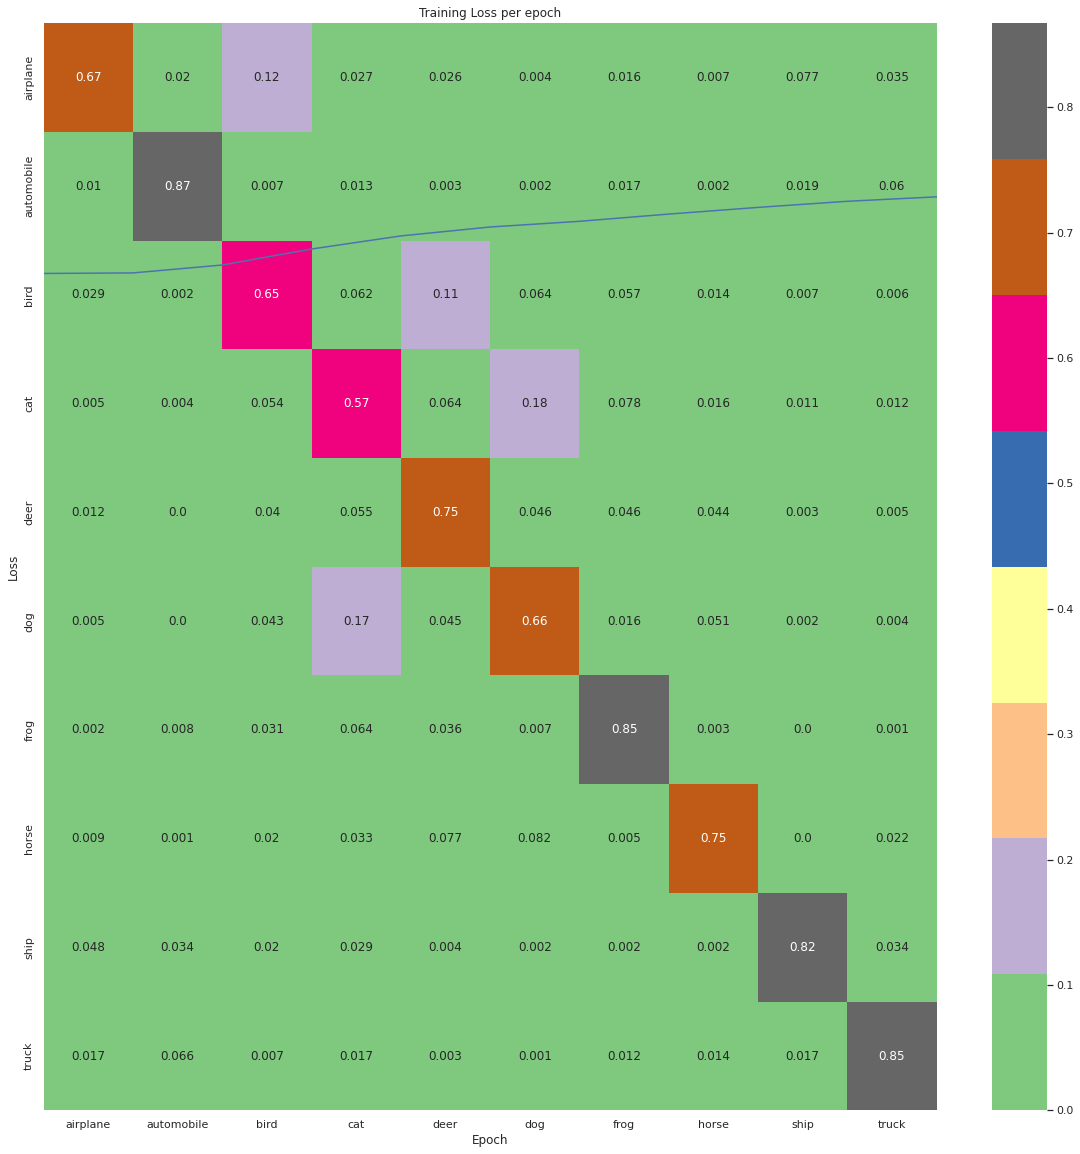

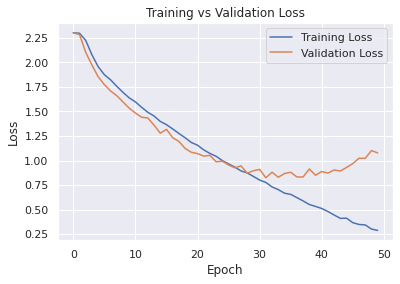

Test Loss: 1.096895
Overall Accuracy: 73.47%

Confusion Matrix 
[[738  22  91  29  13   2  10   1  74  20]
 [ 16 868   8  10   2   4  17   1  32  42]
 [ 44   1 678  88  61  69  45   5   7   2]
 [ 13   4  65 593  32 198  64   7  16   8]
 [ 13   0  75  90 646  58  75  31   9   3]
 [  3   2  34 214  39 665  16  20   2   5]
 [  3   7  52  86  11   8 828   0   3   2]
 [ 12   0  30  75  60 114   4 683   3  19]
 [ 59  19  14  30   3   2   2   1 855  15]
 [ 33  89   5  24   2   3  11   5  35 793]]
Class Name: airplane
	Test Accuracy = 73.80%
	Test Precision = 79.01%
	Test Recall = 73.80%
	Test F1 Score = 76.32%
Class Name: automobile
	Test Accuracy = 86.80%
	Test Precision = 85.77%
	Test Recall = 86.80%
	Test F1 Score = 86.28%
Class Name: bird
	Test Accuracy = 67.80%
	Test Precision = 64.45%
	Test Recall = 67.80%
	Test F1 Score = 66.08%
Class Name: cat
	Test Accuracy = 59.30%
	Test Precision = 47.86%
	Test Recall = 59.30%
	Test F1 Score = 52.97%
Class Name: deer
	Test Accuracy = 64.60%
	Test P

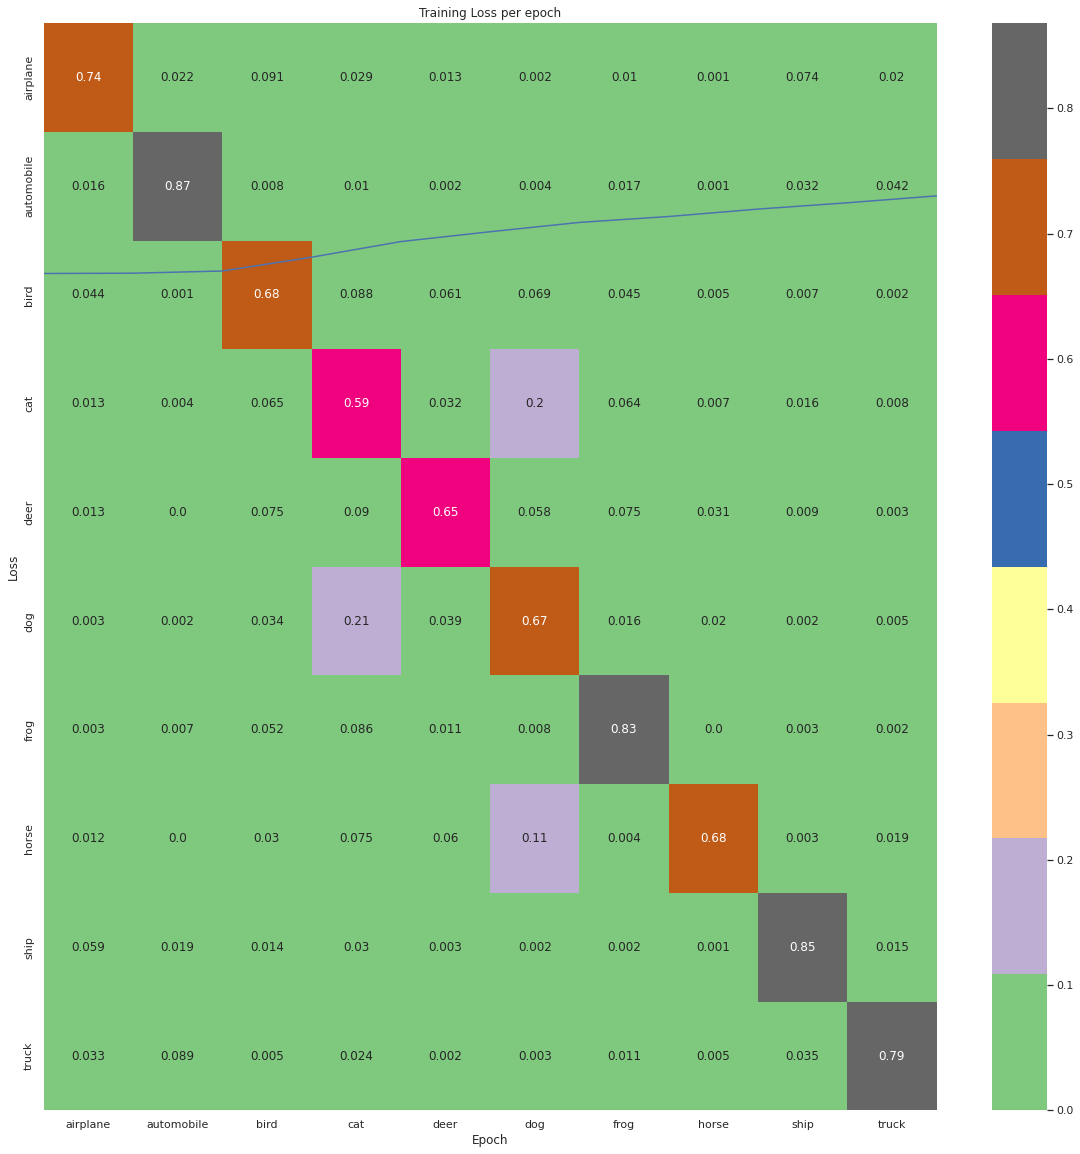

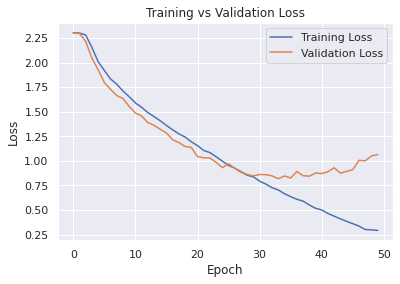

Test Loss: 1.065043
Overall Accuracy: 74.54%

Confusion Matrix 
[[720  13  85   7  43   6   6  20  61  39]
 [ 16 843   6   5   4   2  11   4  28  81]
 [ 32   4 640  41 142  53  36  32  10  10]
 [ 14   7  64 452  78 227  66  49  16  27]
 [  9   0  36  23 807  28  22  64   6   5]
 [  4   2  33 110  79 659  14  88   4   7]
 [  7   6  40  44  64   6 819   6   5   3]
 [ 11   1  16  14  73  44   3 830   1   7]
 [ 58  27  15   9   4   2   4   4 841  36]
 [ 25  55   5   9   6   2   4  24  27 843]]
Class Name: airplane
	Test Accuracy = 72.00%
	Test Precision = 80.36%
	Test Recall = 72.00%
	Test F1 Score = 75.95%
Class Name: automobile
	Test Accuracy = 84.30%
	Test Precision = 88.00%
	Test Recall = 84.30%
	Test F1 Score = 86.11%
Class Name: bird
	Test Accuracy = 64.00%
	Test Precision = 68.09%
	Test Recall = 64.00%
	Test F1 Score = 65.98%
Class Name: cat
	Test Accuracy = 45.20%
	Test Precision = 63.31%
	Test Recall = 45.20%
	Test F1 Score = 52.74%
Class Name: deer
	Test Accuracy = 80.70%
	Test P

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


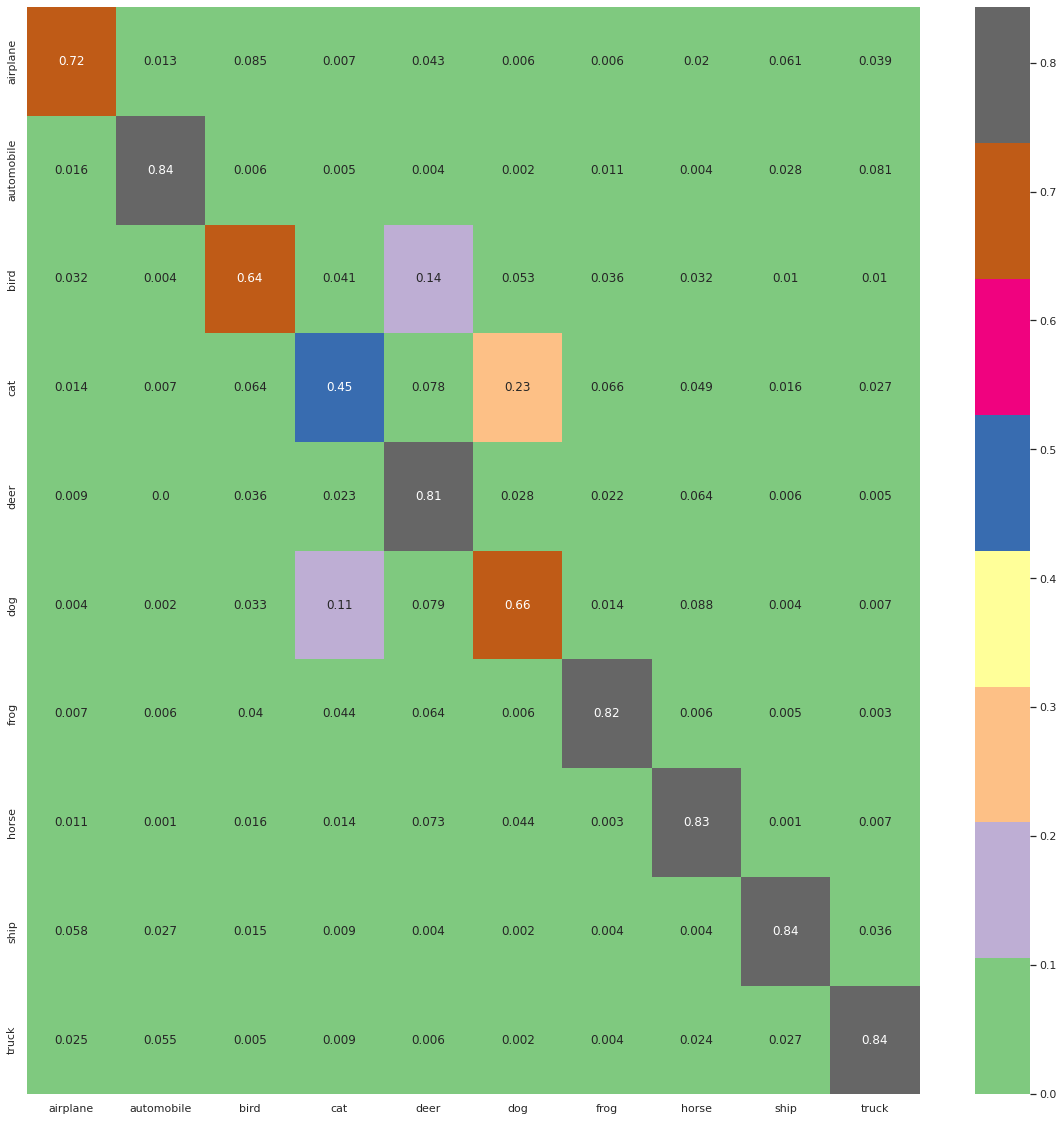

In [14]:
print('Training & Testing for TASK 1')
task_number = 1
iterative_running(task_number)
print('Training & Testing for TASK 1')

In [ ]:
# print(f'Overall Accuracy \n{overall_accuracy}')
# print(f'Overall Precision \n{overall_precision}')
# print(f'Overall Recall \n{overall_recall}')
# print(f'Overall F1 Score \n{overall_f1_score}')


## Task 2: Data Augmentation

Perform the following data augmentation techniques to increase the number of samples in your train set:

1. Rotate Image at an arbitrary angle 
2. Crop Image from the center and resize
3. Flip Image from left to right (Create a mirror image)

Train your network on the augmented dataset 5 times with different seeds and campare results with previously trained network on Test Set.

We usually do Data Augmentation to increase the training set for the model. As the number of samples increases the model accuracy increases as the model is trained on larger data set. 

Moreover, data augmentation helps in areas when we have limited training dataset. Especially in computer vision tasks. Like in this assignment.

Files already downloaded and verified
Training and Testing TASK 2!!
Iteration : 0/5 	 Seed Value: 2916
Epoch: 1 	Training Loss: 2.303044 	Validation Loss: 2.301873
Validation loss decreased (inf --> 2.301873)
Validation Accuracy of airplane:  0% ( 0/1007)
Validation Accuracy of automobile:  0% ( 0/1008)
Validation Accuracy of  bird:  0% ( 0/1005)
Validation Accuracy of   cat:  0% ( 0/998)
Validation Accuracy of  deer:  0% ( 0/947)
Validation Accuracy of   dog:  0% ( 0/999)
Validation Accuracy of  frog:  0% ( 0/983)
Validation Accuracy of horse: 98% (986/1001)
Validation Accuracy of  ship:  0% ( 0/1029)
Validation Accuracy of truck:  3% (33/1023)

Validation Accuracy (Overall): 10% (1019/10000)
Epoch: 2 	Training Loss: 2.300731 	Validation Loss: 2.297013
Validation loss decreased (2.301873 --> 2.297013)
Validation Accuracy of airplane: 47% (482/1007)
Validation Accuracy of automobile: 25% (262/1008)
Validation Accuracy of  bird:  0% ( 0/1005)
Validation Accuracy of   cat:  0% ( 0/998)
V

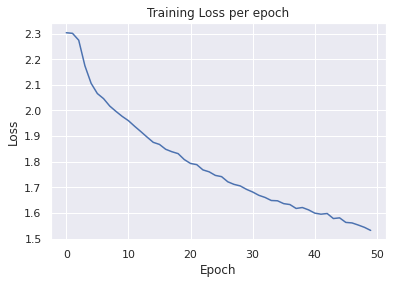

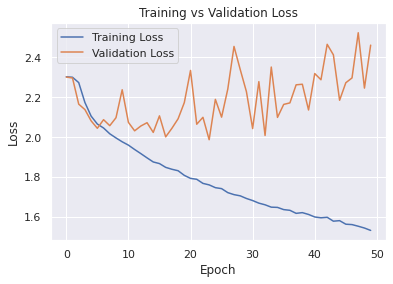

Test Loss: 2.480603
Overall Accuracy: 25.62%

Confusion Matrix 
[[610  29  32   3   0   3  27   6 254  36]
 [306 143  42   5   0   0  42   1 324 137]
 [186   8  99  19  24   6 367  30 111 150]
 [ 91   9  57  64   7  34 242  36 186 274]
 [ 85   6  88  26  48   3 518  22  99 105]
 [ 50   6  53  60  21  48 181  60 158 363]
 [ 81   1  58  17  12   3 683   5  77  63]
 [154  18 117  20  40   9 114 113 168 247]
 [371  16  22   3   0   0  26   0 536  26]
 [237  45  16   1   0   2  32   2 447 218]]
Class Name: airplane
	Test Accuracy = 61.00%
	Test Precision = 28.10%
	Test Recall = 61.00%
	Test F1 Score = 38.47%
Class Name: automobile
	Test Accuracy = 14.30%
	Test Precision = 50.89%
	Test Recall = 14.30%
	Test F1 Score = 22.33%
Class Name: bird
	Test Accuracy = 9.90%
	Test Precision = 16.95%
	Test Recall = 9.90%
	Test F1 Score = 12.50%
Class Name: cat
	Test Accuracy = 6.40%
	Test Precision = 29.36%
	Test Recall = 6.40%
	Test F1 Score = 10.51%
Class Name: deer
	Test Accuracy = 4.80%
	Test Precis

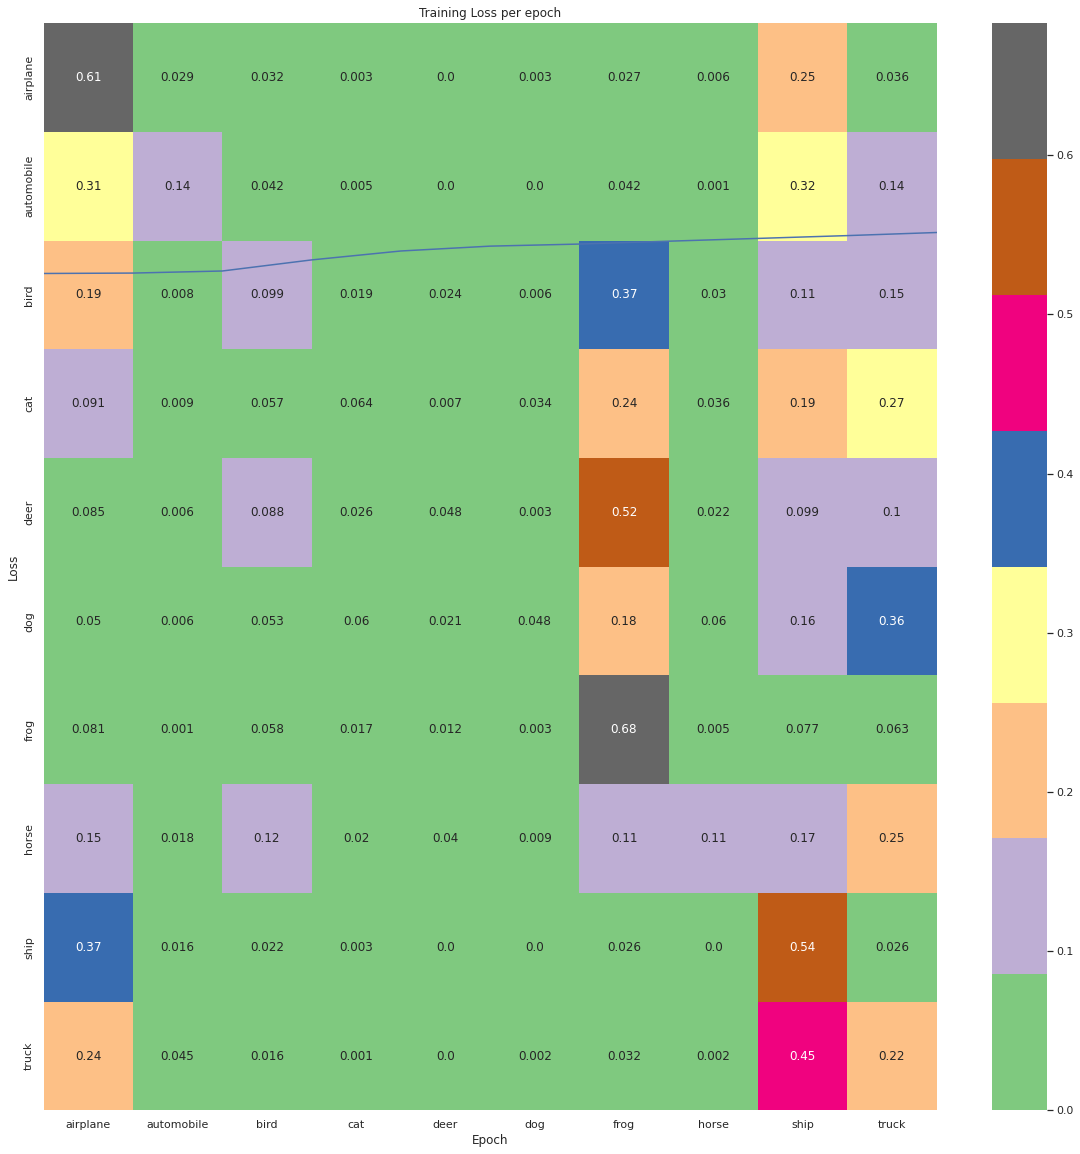

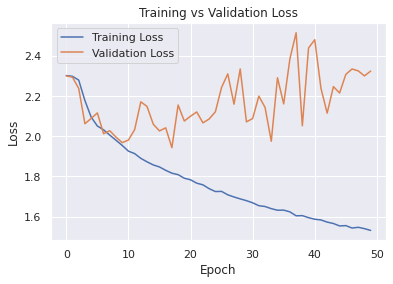

Test Loss: 2.325706
Overall Accuracy: 27.68%

Confusion Matrix 
[[582  51  15   1   0   4  15   7 273  52]
 [313 243  18   5   0   1  12   5 199 204]
 [197  19 135  19  67  10 214  34 118 187]
 [ 88  23  50  48  20  75 155  55 149 337]
 [ 85  17 100  30 141  11 327  24 114 151]
 [ 48  21  53  54  47  89 110  75 124 379]
 [ 83   1  53  25  47   6 545   8 101 131]
 [147  51  77   8  51  18  90 124 123 311]
 [327  64  10   2   0   1  16   0 528  52]
 [241  92  10   4   0   2  11   5 302 333]]
Class Name: airplane
	Test Accuracy = 58.20%
	Test Precision = 27.57%
	Test Recall = 58.20%
	Test F1 Score = 37.42%
Class Name: automobile
	Test Accuracy = 24.30%
	Test Precision = 41.75%
	Test Recall = 24.30%
	Test F1 Score = 30.72%
Class Name: bird
	Test Accuracy = 13.50%
	Test Precision = 25.91%
	Test Recall = 13.50%
	Test F1 Score = 17.75%
Class Name: cat
	Test Accuracy = 4.80%
	Test Precision = 24.49%
	Test Recall = 4.80%
	Test F1 Score = 8.03%
Class Name: deer
	Test Accuracy = 14.10%
	Test Prec

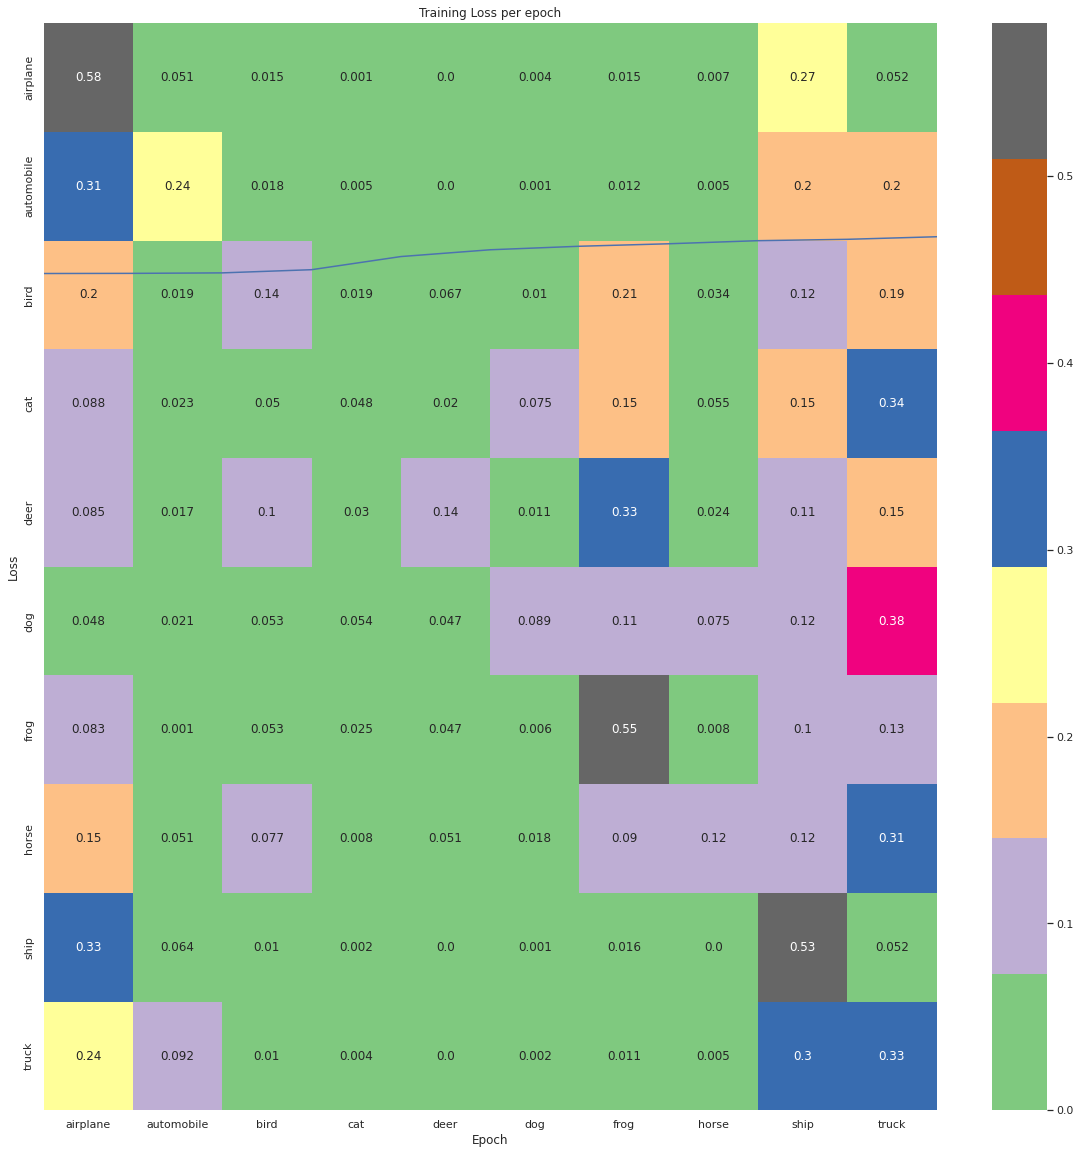

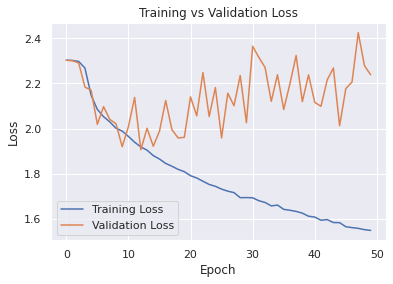

Test Loss: 2.251515
Overall Accuracy: 29.16%

Confusion Matrix 
[[636  44  12   2   1   3  25   3 224  50]
 [345 246  13   1   1   1  32   8 194 159]
 [190  16 136  14  72  10 287  19 112 144]
 [101  23  68  84  18  62 235  38 144 227]
 [114  10 106  17 126   5 439  21  80  82]
 [ 52  19  62  71  57  93 181  61 107 297]
 [ 84   6  44  15  37   4 647   6  76  81]
 [200  32 155  16  64  14  94 123  83 219]
 [359  44   3   0   1   0  22   1 520  50]
 [280 104   8   1   0   1  31   2 268 305]]
Class Name: airplane
	Test Accuracy = 63.60%
	Test Precision = 26.94%
	Test Recall = 63.60%
	Test F1 Score = 37.85%
Class Name: automobile
	Test Accuracy = 24.60%
	Test Precision = 45.22%
	Test Recall = 24.60%
	Test F1 Score = 31.87%
Class Name: bird
	Test Accuracy = 13.60%
	Test Precision = 22.41%
	Test Recall = 13.60%
	Test F1 Score = 16.93%
Class Name: cat
	Test Accuracy = 8.40%
	Test Precision = 38.01%
	Test Recall = 8.40%
	Test F1 Score = 13.76%
Class Name: deer
	Test Accuracy = 12.60%
	Test Pre

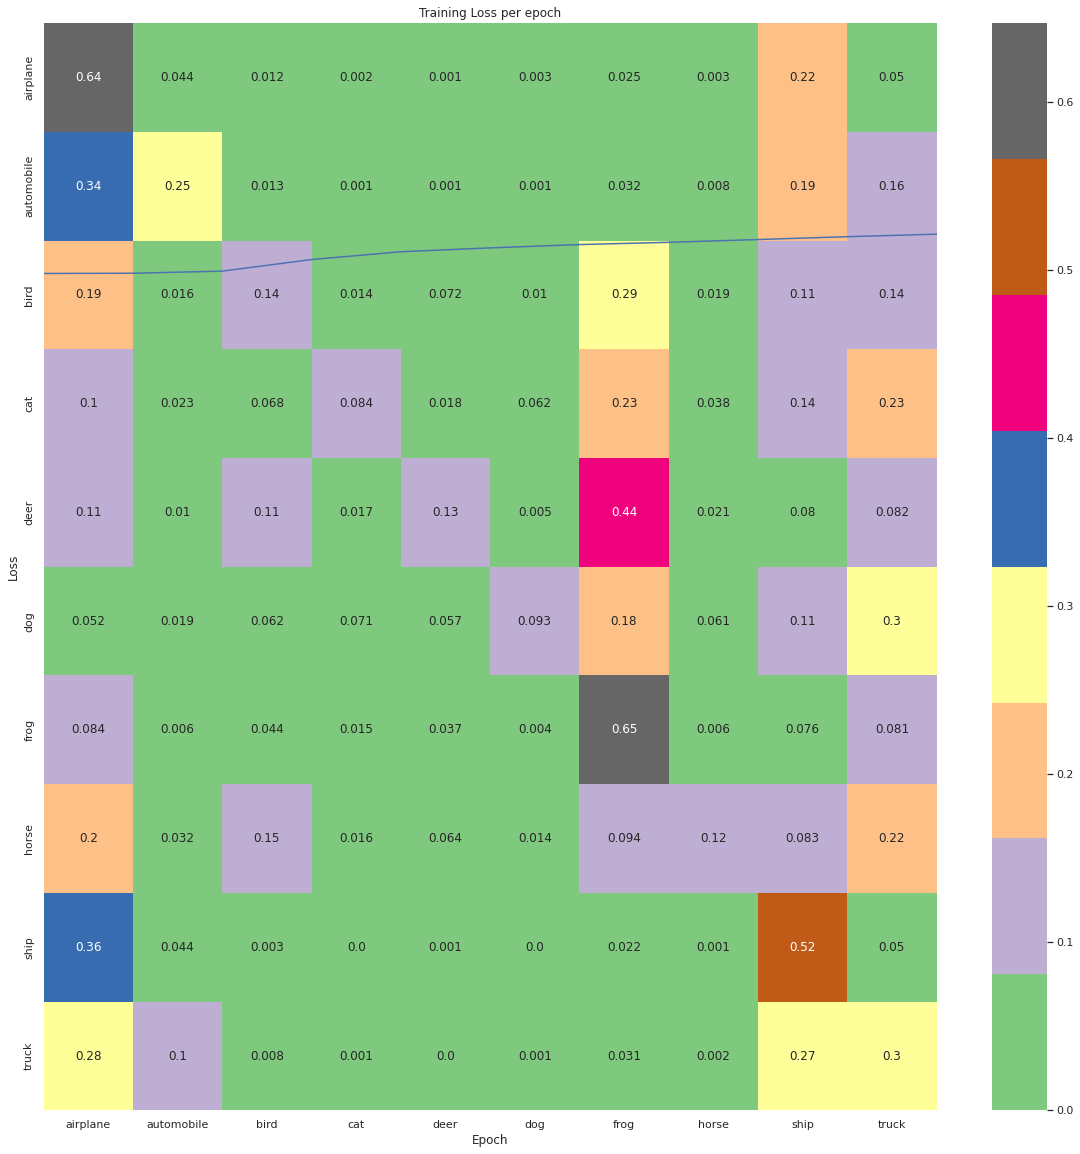

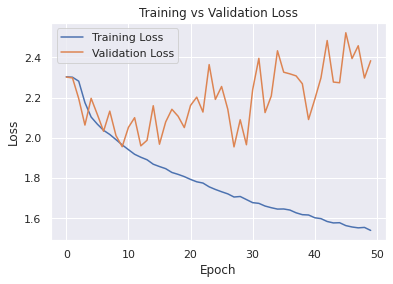

Test Loss: 2.392684
Overall Accuracy: 26.83%

Confusion Matrix 
[[647  67   7   0   1   3  13   9 206  47]
 [263 338  16   4   0   2  18   6 185 168]
 [217  21  93  18  20  11 261  35 121 203]
 [101  39  24  40   6  56 156  38 151 389]
 [127  21  57  13  51   7 415  18 107 184]
 [ 50  25  34  41  25  82 115  57 123 448]
 [ 99   5  31  14  17   4 586   4  93 147]
 [243  82  61   6  23  14  68  88 125 290]
 [373  56   6   1   0   0  15   0 497  52]
 [270 156   4   3   0   1  15   2 288 261]]
Class Name: airplane
	Test Accuracy = 64.70%
	Test Precision = 27.07%
	Test Recall = 64.70%
	Test F1 Score = 38.17%
Class Name: automobile
	Test Accuracy = 33.80%
	Test Precision = 41.73%
	Test Recall = 33.80%
	Test F1 Score = 37.35%
Class Name: bird
	Test Accuracy = 9.30%
	Test Precision = 27.93%
	Test Recall = 9.30%
	Test F1 Score = 13.95%
Class Name: cat
	Test Accuracy = 4.00%
	Test Precision = 28.57%
	Test Recall = 4.00%
	Test F1 Score = 7.02%
Class Name: deer
	Test Accuracy = 5.10%
	Test Precisi

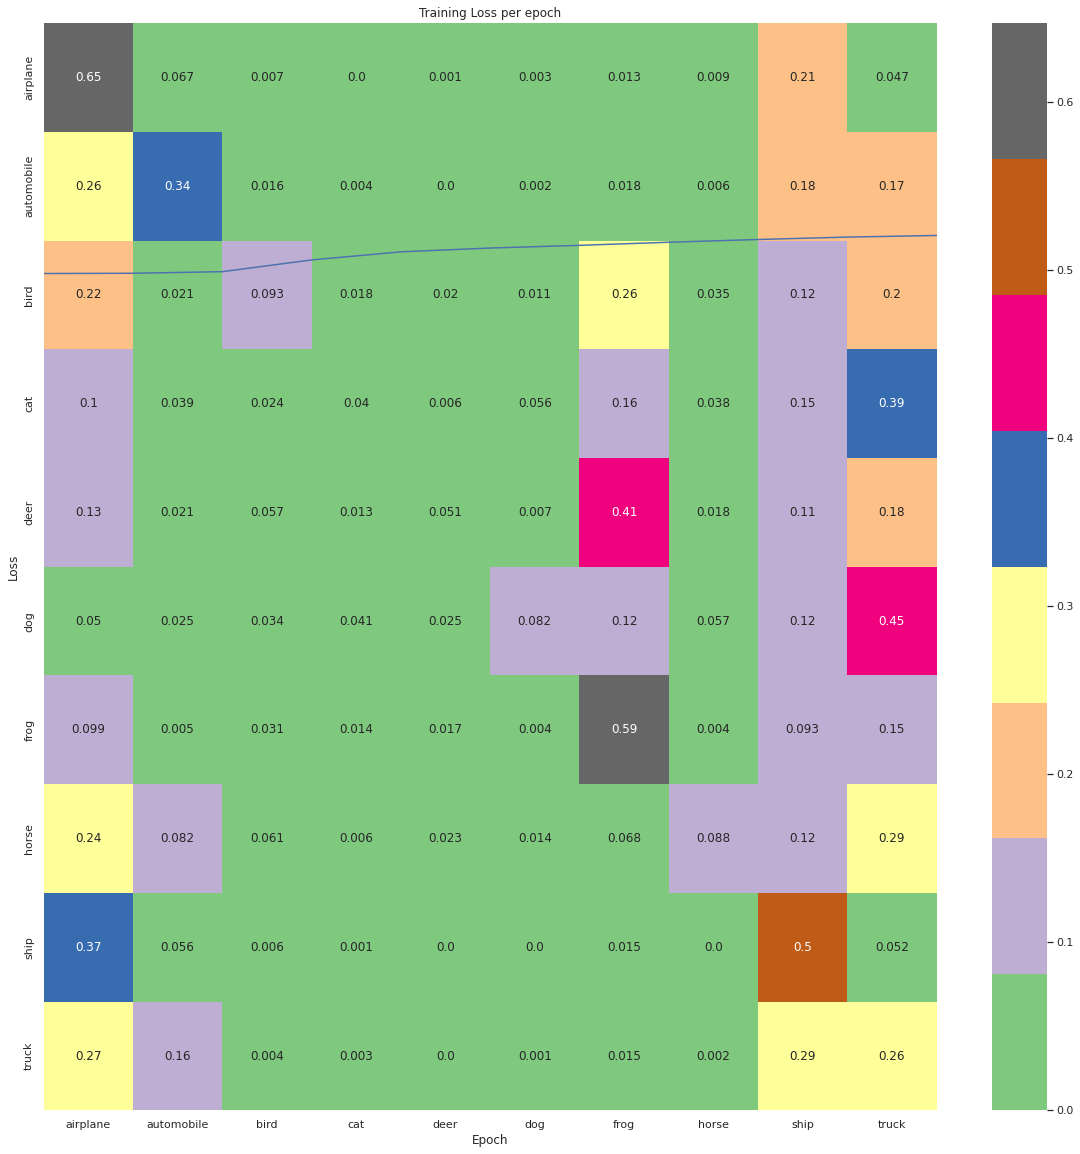

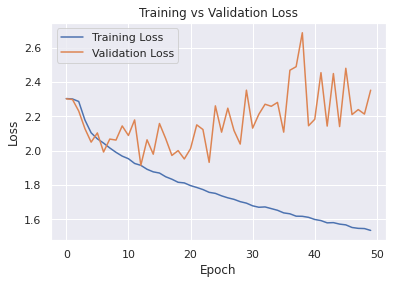

Test Loss: 2.356611
Overall Accuracy: 27.94%

Confusion Matrix 
[[632  33  22   1   1   5  10   3 247  46]
 [335 205  18   4   1   1   9   3 262 162]
 [217  12 146  20  53  10 215  40 114 173]
 [128  20  68  55  17  68 145  45 160 294]
 [116  13 116  30 134   4 313  37 120 117]
 [ 69  17  56  41  45  93  73  90 137 379]
 [100   2  61  17  44   4 553   6  97 116]
 [248  46  68   4  49  18  44 133 133 257]
 [332  22  15   2   0   1  11   0 586  31]
 [291  72   8   3   0   0  13   2 354 257]]
Class Name: airplane
	Test Accuracy = 63.20%
	Test Precision = 25.61%
	Test Recall = 63.20%
	Test F1 Score = 36.45%
Class Name: automobile
	Test Accuracy = 20.50%
	Test Precision = 46.38%
	Test Recall = 20.50%
	Test F1 Score = 28.43%
Class Name: bird
	Test Accuracy = 14.60%
	Test Precision = 25.26%
	Test Recall = 14.60%
	Test F1 Score = 18.50%
Class Name: cat
	Test Accuracy = 5.50%
	Test Precision = 31.07%
	Test Recall = 5.50%
	Test F1 Score = 9.35%
Class Name: deer
	Test Accuracy = 13.40%
	Test Prec

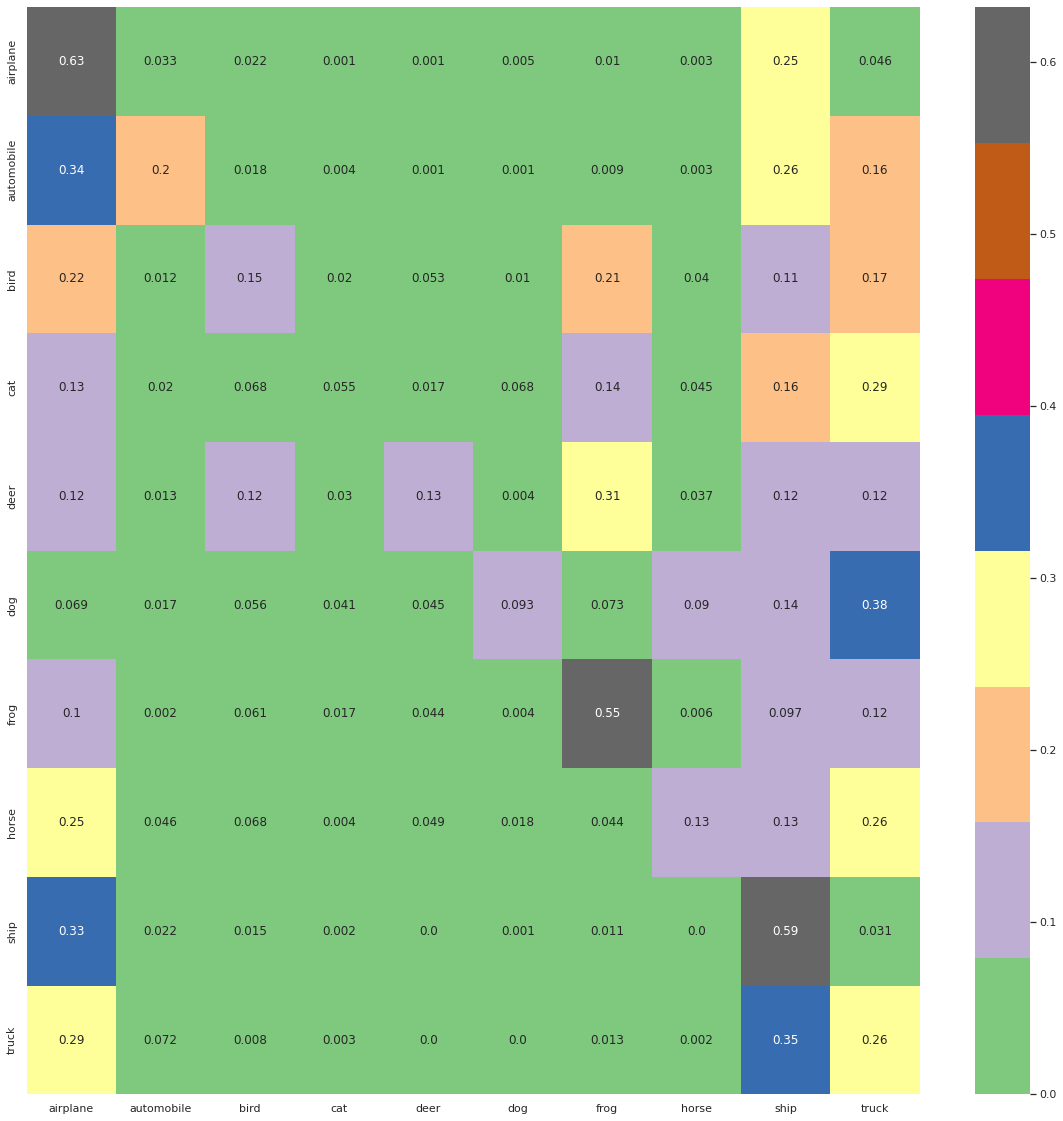

In [16]:
# Augmenting the data
aug_train = T.Compose([T.RandomRotation(45), #Rotating
                        T.CenterCrop(12), #Cropping and resizing
                        T.Resize((32,32)), #resizing to 32*32
                        T.RandomHorizontalFlip(), #Flipping
                        T.ToTensor(), 
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform = aug_train
)
train_data = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

#val_dataset, train_dataset = torch.utils.data.random_split(train_dataset_augmented, [10000, 40000])
print('Training and Testing TASK 2!!')
task_number = 2
iterative_running(task_number)
print('Finished Training and Testing TASK 2!!')

Above shows that as we train the model on the augented data we see that the model is becoming more stable and given better accuracy.

Convergence is still at same pace.

In [ ]:
print('Printing images from Augmented Train Data!!!!')
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

## Task 3: Adversarial Samples

1. Create a Adversarial Test Set by adding a noise sampled from $\sim\mathcal{N}(\mu = 0, \sigma = 0.01)$ to the given Test Set.
2. Compare models obtained in Task 1 and Task 2 on Adversarial Test Set
3. Augment train set by adding noise to samples from train set. (You should have both normal samples and noise added samples in train set)
4. Train your model 5 times with different seeds on noise augmented train set and report results on normal Test Set and Adversarial Test Set 

In [ ]:
#---------------------------------------------------
# Creating the random normal noise with given mean and standard deviation 
#---------------------------------------------------
from torch.utils.data import Subset

# Create a copy of the test dataset
test_data_copy = Subset(test_data, range(len(test_data)))
train_data_copy = Subset(train_data, range(len(train_data)))

#Adding gaussian noise to the training and testing dataset
def add_noise(dataset, mean=0., std_dev=0.01):
    return dataset + torch.randn(dataset.size()) * std_dev + mean

noisy_transform = T.Compose([T.ToTensor(),T.Lambda(add_noise),
])

#---------------------------------------------------
# Augmenting training and testing dataset by adding the noise (Part 1, 3)
#---------------------------------------------------
test_dataset = datasets.CIFAR10("data", train=False, download=True, transform=noisy_transform)
train_dataset = datasets.CIFAR10("data", train=False, download=True, transform=noisy_transform)

test_data = DataLoader(test_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)
train_data = DataLoader(train_dataset, batch_size = batch_size)

# print('Printing images from Noisy Test Data!!!!')
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 5, 5
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
#     img, label = train_dataset[sample_idx]
#     label = idx_to_class[label]
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.permute(1, 2, 0).squeeze())
# plt.show()



In [19]:
# Running the models saved in TASK 1 and TASK 2 to compare the results on the new test_Dataset
# Task 3 (2)
def testing_task_3(model, test_data):
  
  accuracy_task3 = []
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  total_labels = []
  total_probs = []

  model.eval()
  # iterate over test data
  for data, target in enumerate(test_data):
      inputs, labels = target
      inputs, labels = inputs.cuda(), labels.cuda()

      with torch.no_grad():
        output = model(inputs)
        probs = torch.argmax(output, dim=1)

        # calculate the loss
        loss = loss_fn(output, labels)
        # update test loss 
        test_loss += loss.item()*inputs.size(0)
        total_labels += labels.cpu().numpy().tolist()
        total_probs += probs.cpu().numpy().tolist()

        correct_tensor = probs.eq(labels.data.view_as(probs))
        correct = np.squeeze(correct_tensor.cpu().numpy())

        # calculate test accuracy for each object class
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  # average test loss
  test_loss = test_loss/len(test_data.dataset)
  print('Test Loss: {:.6f}'.format(test_loss))

  #calcualting the model accuracy
  accuracy_task3 = np.array([class_correct[i]/class_total[i] for i in range(len(class_names))])

  for i in range(len(class_names)):
    print(f'Class Name: {class_names[i]}')
    print('\tTest Accuracy = {:.2f}%'.format(accuracy_task3[i] * 100))


Testing loss is higher on the Models trained in Task 2 as compared to the models trained in Task 1.

In [21]:
#---------------------------------------------------
# Running the saved 5 models from Task 1 and Task 2 each on the augmented noisy test set.
#---------------------------------------------------
for i in range(1,3):
  for j in range(0,5):
    model_name = f'model_{str(i)}_{str(j)}.pt'
    print(model_name)
    model.load_state_dict(torch.load(model_name))
    testing_task_3(model,test_data)

model_1_0.pt
Test Loss: 2.042613
Class Name: airplane
	Test Accuracy = 83.00%
Class Name: automobile
	Test Accuracy = 30.80%
Class Name: bird
	Test Accuracy = 37.90%
Class Name: cat
	Test Accuracy = 44.80%
Class Name: deer
	Test Accuracy = 45.10%
Class Name: dog
	Test Accuracy = 48.90%
Class Name: frog
	Test Accuracy = 20.80%
Class Name: horse
	Test Accuracy = 52.10%
Class Name: ship
	Test Accuracy = 87.30%
Class Name: truck
	Test Accuracy = 36.10%
model_1_1.pt
Test Loss: 1.841324
Class Name: airplane
	Test Accuracy = 66.70%
Class Name: automobile
	Test Accuracy = 27.00%
Class Name: bird
	Test Accuracy = 33.80%
Class Name: cat
	Test Accuracy = 65.80%
Class Name: deer
	Test Accuracy = 48.50%
Class Name: dog
	Test Accuracy = 55.80%
Class Name: frog
	Test Accuracy = 27.10%
Class Name: horse
	Test Accuracy = 50.10%
Class Name: ship
	Test Accuracy = 88.40%
Class Name: truck
	Test Accuracy = 40.20%
model_1_2.pt
Test Loss: 1.708775
Class Name: airplane
	Test Accuracy = 64.50%
Class Name: auto

In [ ]:
#training the model 5 times on the Train your model 5 times 
#with different seeds on noise augmented train set and testing on the "augmented test set"
task_number = 3
iterative_running(task_number)

In [30]:
#Testing the results on the saved trained models on normal Test Set 
test_dataset = datasets.CIFAR10("data", train=False, download=False, transform=transform)
test_data = DataLoader(test_dataset, batch_size = batch_size)

for i in range(0,5):
  model_name = f'model_3_{str(i)}.pt'
  print(model_name)
  model.load_state_dict(torch.load(model_name))
  testing_task_3(model,test_data)

model_3_0.pt
Test Loss: 2.922999
Class Name: airplane
	Test Accuracy = 24.30%
Class Name: automobile
	Test Accuracy = 96.70%
Class Name: bird
	Test Accuracy = 0.00%
Class Name: cat
	Test Accuracy = 4.00%
Class Name: deer
	Test Accuracy = 2.30%
Class Name: dog
	Test Accuracy = 17.70%
Class Name: frog
	Test Accuracy = 16.10%
Class Name: horse
	Test Accuracy = 30.40%
Class Name: ship
	Test Accuracy = 5.40%
Class Name: truck
	Test Accuracy = 2.30%
model_3_1.pt
Test Loss: 2.369632
Class Name: airplane
	Test Accuracy = 20.00%
Class Name: automobile
	Test Accuracy = 90.60%
Class Name: bird
	Test Accuracy = 0.30%
Class Name: cat
	Test Accuracy = 7.20%
Class Name: deer
	Test Accuracy = 3.30%
Class Name: dog
	Test Accuracy = 21.50%
Class Name: frog
	Test Accuracy = 28.30%
Class Name: horse
	Test Accuracy = 41.20%
Class Name: ship
	Test Accuracy = 9.40%
Class Name: truck
	Test Accuracy = 16.70%
model_3_2.pt
Test Loss: 2.502979
Class Name: airplane
	Test Accuracy = 23.00%
Class Name: automobile
	T

As per the reference [3] it is mentioned that we train the deep learning model with the noisy data in order to make the network more stable and protect it from the false or noisy data. This helps the network maitain better accuracy by reducing the number of false positives.

It can be observed from the accuracy of the training and test data that the with the noisy test data and normal test data there is a drop in the model's accuracy as we move further with training to the same number of epochs as in Task 1 and Task 2.
It is observed that the gap between the training and validation loss reduced initally but as the number of epochs increased the model showed overfitting trends. However, slight improvement in the test accuracy can be observed.


References:
 
1.   https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch
2.  https://www.kaggle.com/code/whatsthevariance/pytorch-cnn-cifar10-68-70-test-accuracy
3. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html 
4. https://stackoverflow.com/questions/59090533/how-do-i-add-some-gaussian-noise-to-a-tensor-in-pytorch
5. https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d 

